# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
import pingouin
import math

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable for treatment status

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1:

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

**Answer.**

In [3]:
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
lalonde_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, NSW1 to PSID429
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   treat     614 non-null    int64  
 1   age       614 non-null    int64  
 2   educ      614 non-null    int64  
 3   black     614 non-null    int64  
 4   hispan    614 non-null    int64  
 5   married   614 non-null    int64  
 6   nodegree  614 non-null    int64  
 7   re74      614 non-null    float64
 8   re75      614 non-null    float64
 9   re78      614 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 52.8+ KB


In [5]:
lalonde_df.groupby('treat')['re78'].agg('mean').reset_index()

,treat,re78
0,0,6984.169742
1,1,6349.143530


In [6]:
lalonde_df.groupby('treat')['re78'].agg('median').reset_index()

,treat,re78
0,0,4975.505
1,1,4232.309


-------

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.**

In [7]:
lalonde_df['treat'].value_counts()

0    429
1    185
Name: treat, dtype: int64

**Note: Control group (treat=0), Treatment group (treat=1)**

In [8]:
print('The percentage of workers who are in the treatment group is',str(round(lalonde_df['treat'].value_counts()[1]/
      (lalonde_df['treat'].value_counts()[0]+lalonde_df['treat'].value_counts()[1])*100,1)),'%')

The percentage of workers who are in the treatment group is 30.1 %


Now, lets check the mean, median and Ttest for the two subsets

In [9]:
# Two subsets by treat with the column of earning re78
df_re78_treat_0 = lalonde_df[lalonde_df['treat']==0]['re78']
df_re78_treat_1 = lalonde_df[lalonde_df['treat']==1]['re78']
    
# Lets check the mean
print('The mean of earnings re78 for the group treat 0 is',str(round(df_re78_treat_0.mean(),1)))
print('The mean of earnings re78 for the group treat 1 is',str(round(df_re78_treat_1.mean(),1))) 

The mean of earnings re78 for the group treat 0 is 6984.2
The mean of earnings re78 for the group treat 1 is 6349.1


In [10]:
# Lets check the median
print('The median of earnings re78 for the group treat 0 is',str(round(df_re78_treat_0.median(),1)))
print('The median of earnings re78 for the group treat 1 is',str(round(df_re78_treat_1.median(),1)))

The median of earnings re78 for the group treat 0 is 4975.5
The median of earnings re78 for the group treat 1 is 4232.3


In [11]:
# T test
pingouin.ttest(df_re78_treat_0,df_re78_treat_1)['p-val']

T-test    0.349077
Name: p-val, dtype: float64


According to the test results, the null hypothesis, which states that there is a statistically significant difference between the income of each treatment group, cannot be rejected.
2 print with line break in jupyter


-------

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**

-------

Before we start our exploration on causality, let's perform some simple setup:

1. We seperate the `treat` (treatment) indicator from our dataset. We will want to use this as our objective variable to fit models to later
2. We are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [12]:
#First, let's reset the indexes
cleaned_df=lalonde_df.reset_index().drop(['index'],axis=1)

#Create seperate structure for data and target 
treatment = cleaned_df['treat']
rev78 = cleaned_df['re78']
cleaned_df = cleaned_df.drop(['treat', 're78'], axis=1)

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2:

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.**

In [13]:
# Create function to calculate Standardized Mean Differences
def smd(column):
    x_t =  lalonde_df[lalonde_df['treat']==1][column].mean()
    x_c =  lalonde_df[lalonde_df['treat']==0][column].mean()

    s_t = lalonde_df[lalonde_df['treat']==1][column].std()
    s_c = lalonde_df[lalonde_df['treat']==0][column].std()
    
    # Formula
    nume = x_t - x_c
    denom = math.sqrt(((s_t**2)+(s_c**2))/2)
    
    result = nume / denom
    
    return result

In [14]:
for column in cleaned_df:
    a = smd(column)
    print('The column',str(column),'has a value of SMD between treatment and control subset of:',round(a,2))

The column age has a value of SMD between treatment and control subset of: -0.24
The column educ has a value of SMD between treatment and control subset of: 0.04
The column black has a value of SMD between treatment and control subset of: 1.67
The column hispan has a value of SMD between treatment and control subset of: -0.28
The column married has a value of SMD between treatment and control subset of: -0.72
The column nodegree has a value of SMD between treatment and control subset of: 0.24
The column re74 has a value of SMD between treatment and control subset of: -0.6
The column re75 has a value of SMD between treatment and control subset of: -0.29


-------

#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.**

In [15]:
for column in cleaned_df:
    a = smd(column)
    if abs(a) > 0.2:
        print('The column',str(column),'has a |value of SMD| > 0.2, the value is:',round(abs(a),2))

The column age has a |value of SMD| > 0.2, the value is: 0.24
The column black has a |value of SMD| > 0.2, the value is: 1.67
The column hispan has a |value of SMD| > 0.2, the value is: 0.28
The column married has a |value of SMD| > 0.2, the value is: 0.72
The column nodegree has a |value of SMD| > 0.2, the value is: 0.24
The column re74 has a |value of SMD| > 0.2, the value is: 0.6
The column re75 has a |value of SMD| > 0.2, the value is: 0.29


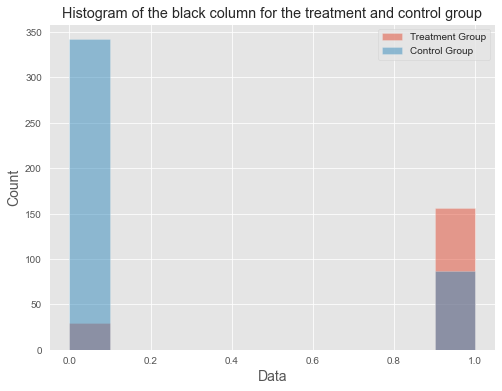

In [16]:
# Subsebt by Treatment and control 
black_t = lalonde_df[lalonde_df['treat']==1]['black']
black_c = lalonde_df[lalonde_df['treat']==0]['black']

# Plot black histogram
plt.figure(figsize=(8,6))
plt.hist(black_t, alpha=0.5, label="Treatment Group")
plt.hist(black_c, alpha=0.5, label="Control Group")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of the black column for the treatment and control group")
plt.legend(loc='upper right')

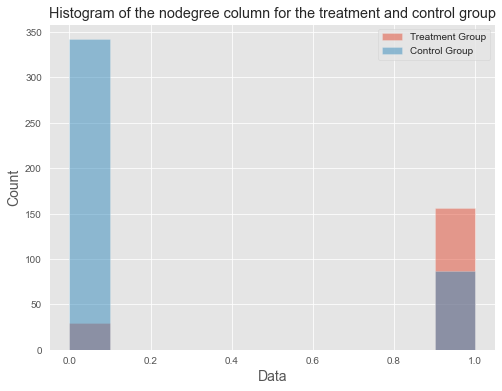

In [17]:
# Subsebt by Treatment and control 
nodegree_t = lalonde_df[lalonde_df['treat']==1]['nodegree']
nodegree_c = lalonde_df[lalonde_df['treat']==0]['nodegree']

# Plot nodegree histograms
plt.figure(figsize=(8,6))
plt.hist(black_t, alpha=0.5, label="Treatment Group")
plt.hist(black_c, alpha=0.5, label="Control Group")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of the nodegree column for the treatment and control group")
plt.legend(loc='upper right')

-------

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3:

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.**

We are going to partition the data in training and testing, we use the StratifiedShuffleSplit function because as the data is not balanced (70%-30%) we must ensure that at the time of partitioning there are no variables of a single group, so we use the following configuration;

In [18]:
# Modelation

cleaned_df['intec'] = 1
logre = sm.Logit(treatment, cleaned_df)
model_logre = logre.fit()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


-------

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.**

In [19]:
pscore_logit = model_logre.predict(cleaned_df)

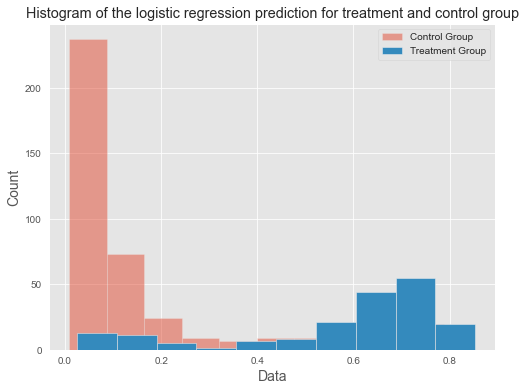

In [20]:
# Plot distributons
plt.figure(figsize=(8,6))
plt.hist(pscore_logit[treatment==0], alpha=0.5, label="Control Group")
plt.hist(pscore_logit[treatment==1], label="Treatment Group")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of the logistic regression prediction for treatment and control group")
plt.legend(loc='upper right')

-------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.**

In [21]:
# Data
df2 = lalonde_df.copy().reset_index()
treat_index = df2[df2['treat']==1].index.values
control_index = df2[df2['treat']==0].index.values

# Groups
treat_pscores = pscore_logit.iloc[treat_index]
control_pscores = pscore_logit.iloc[control_index]

In [22]:
# Model
knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')

model_knn = knn.fit(control_pscores.values.reshape(-1,1))

-------

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

**Answer.**

In [23]:
# Find the kneighbors
distances, index_p = model_knn.kneighbors(treat_pscores.values.reshape(-1,1))

In [24]:
index_knn = index_p[:,0]

-------

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.**

In [25]:
filt = lalonde_df['treat']==1

# Separate
df_treat = lalonde_df[filt]
df_control = lalonde_df[~filt].iloc[index_knn]

In [26]:
# Check df treat
df_treat['treat'].value_counts()

1    185
Name: treat, dtype: int64

In [27]:
# Check df control
df_control['treat'].value_counts()

0    185
Name: treat, dtype: int64

-------

### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

**Answer.**

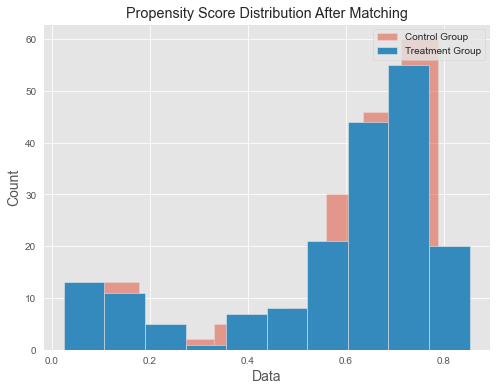

In [28]:
# Plot distributons
plt.figure(figsize=(8,6))
plt.hist(control_pscores.iloc[index_knn], alpha=0.5, label="Control Group")
plt.hist(treat_pscores, label="Treatment Group")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Propensity Score Distribution After Matching")
plt.legend(loc='upper right')

-------

### Exercise 6

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

In [29]:
# Consolidate two groups
df_consol = pd.concat([df_treat, df_control], axis=0)

In [30]:
# Create function smd2
def asmd(column):
    x_t =  df_consol[df_consol['treat']==1][column].mean()
    x_c =  df_consol[df_consol['treat']==0][column].mean()

    s_t = df_consol[df_consol['treat']==1][column].std()
    s_c = df_consol[df_consol['treat']==0][column].std()
    
    # Formula
    nume = x_t - x_c
    denom = math.sqrt(((s_t**2)+(s_c**2))/2)
    
    result = nume / denom
    
    return result

# Lets check the result of SMD
for column in df_consol.loc[:, (df_consol.columns != 'treat')&(df_consol.columns != 're78')]:
    b = asmd(column)
    print('The column',str(column),'has a value of ASMD between treatment and control subset of:',round(b,2))

The column age has a value of ASMD between treatment and control subset of: 0.2
The column educ has a value of ASMD between treatment and control subset of: -0.01
The column black has a value of ASMD between treatment and control subset of: 0.01
The column hispan has a value of ASMD between treatment and control subset of: -0.02
The column married has a value of ASMD between treatment and control subset of: 0.16
The column nodegree has a value of ASMD between treatment and control subset of: 0.01
The column re74 has a value of ASMD between treatment and control subset of: -0.05
The column re75 has a value of ASMD between treatment and control subset of: 0.01


Now lets check the columns with abs values > 0.2 of SMD

In [31]:
for column in df_consol.loc[:, (df_consol.columns != 'treat')&(df_consol.columns != 're78')]:
    b = asmd(column)
    if abs(b) > 0.2:
        print('The column',str(column),'|has a value of ASMD| > 0.2, the value is:',round(abs(b),2))

The column age |has a value of ASMD| > 0.2, the value is: 0.2


-------

### Exercise 7

Estimate the average effect of treatment on wages (`re78`) after matching. What do you conclude?

**Answer.**

In [32]:
df_gb = df_consol.groupby('treat')['re78'].mean().reset_index()
df_gb

,treat,re78
0,0,4574.682159
1,1,6349.143530


In [33]:
df_gb['re78'][1] - df_gb['re78'][0]

1774.4613708108127

A positive effect is observed in the mean difference after matching and all the process we have performed so far. The difference in column re78 earnings between the two groups is positive between the treatment and control groups.

-------

## Propensity score matching using decision trees and random forests

### Exercise 8

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.**

In [34]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate model
regressor= DecisionTreeRegressor(max_depth=4)

# Train model
regressor.fit(cleaned_df,treatment)

# Predict
pscore_tree=regressor.predict(cleaned_df)


-------

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.**

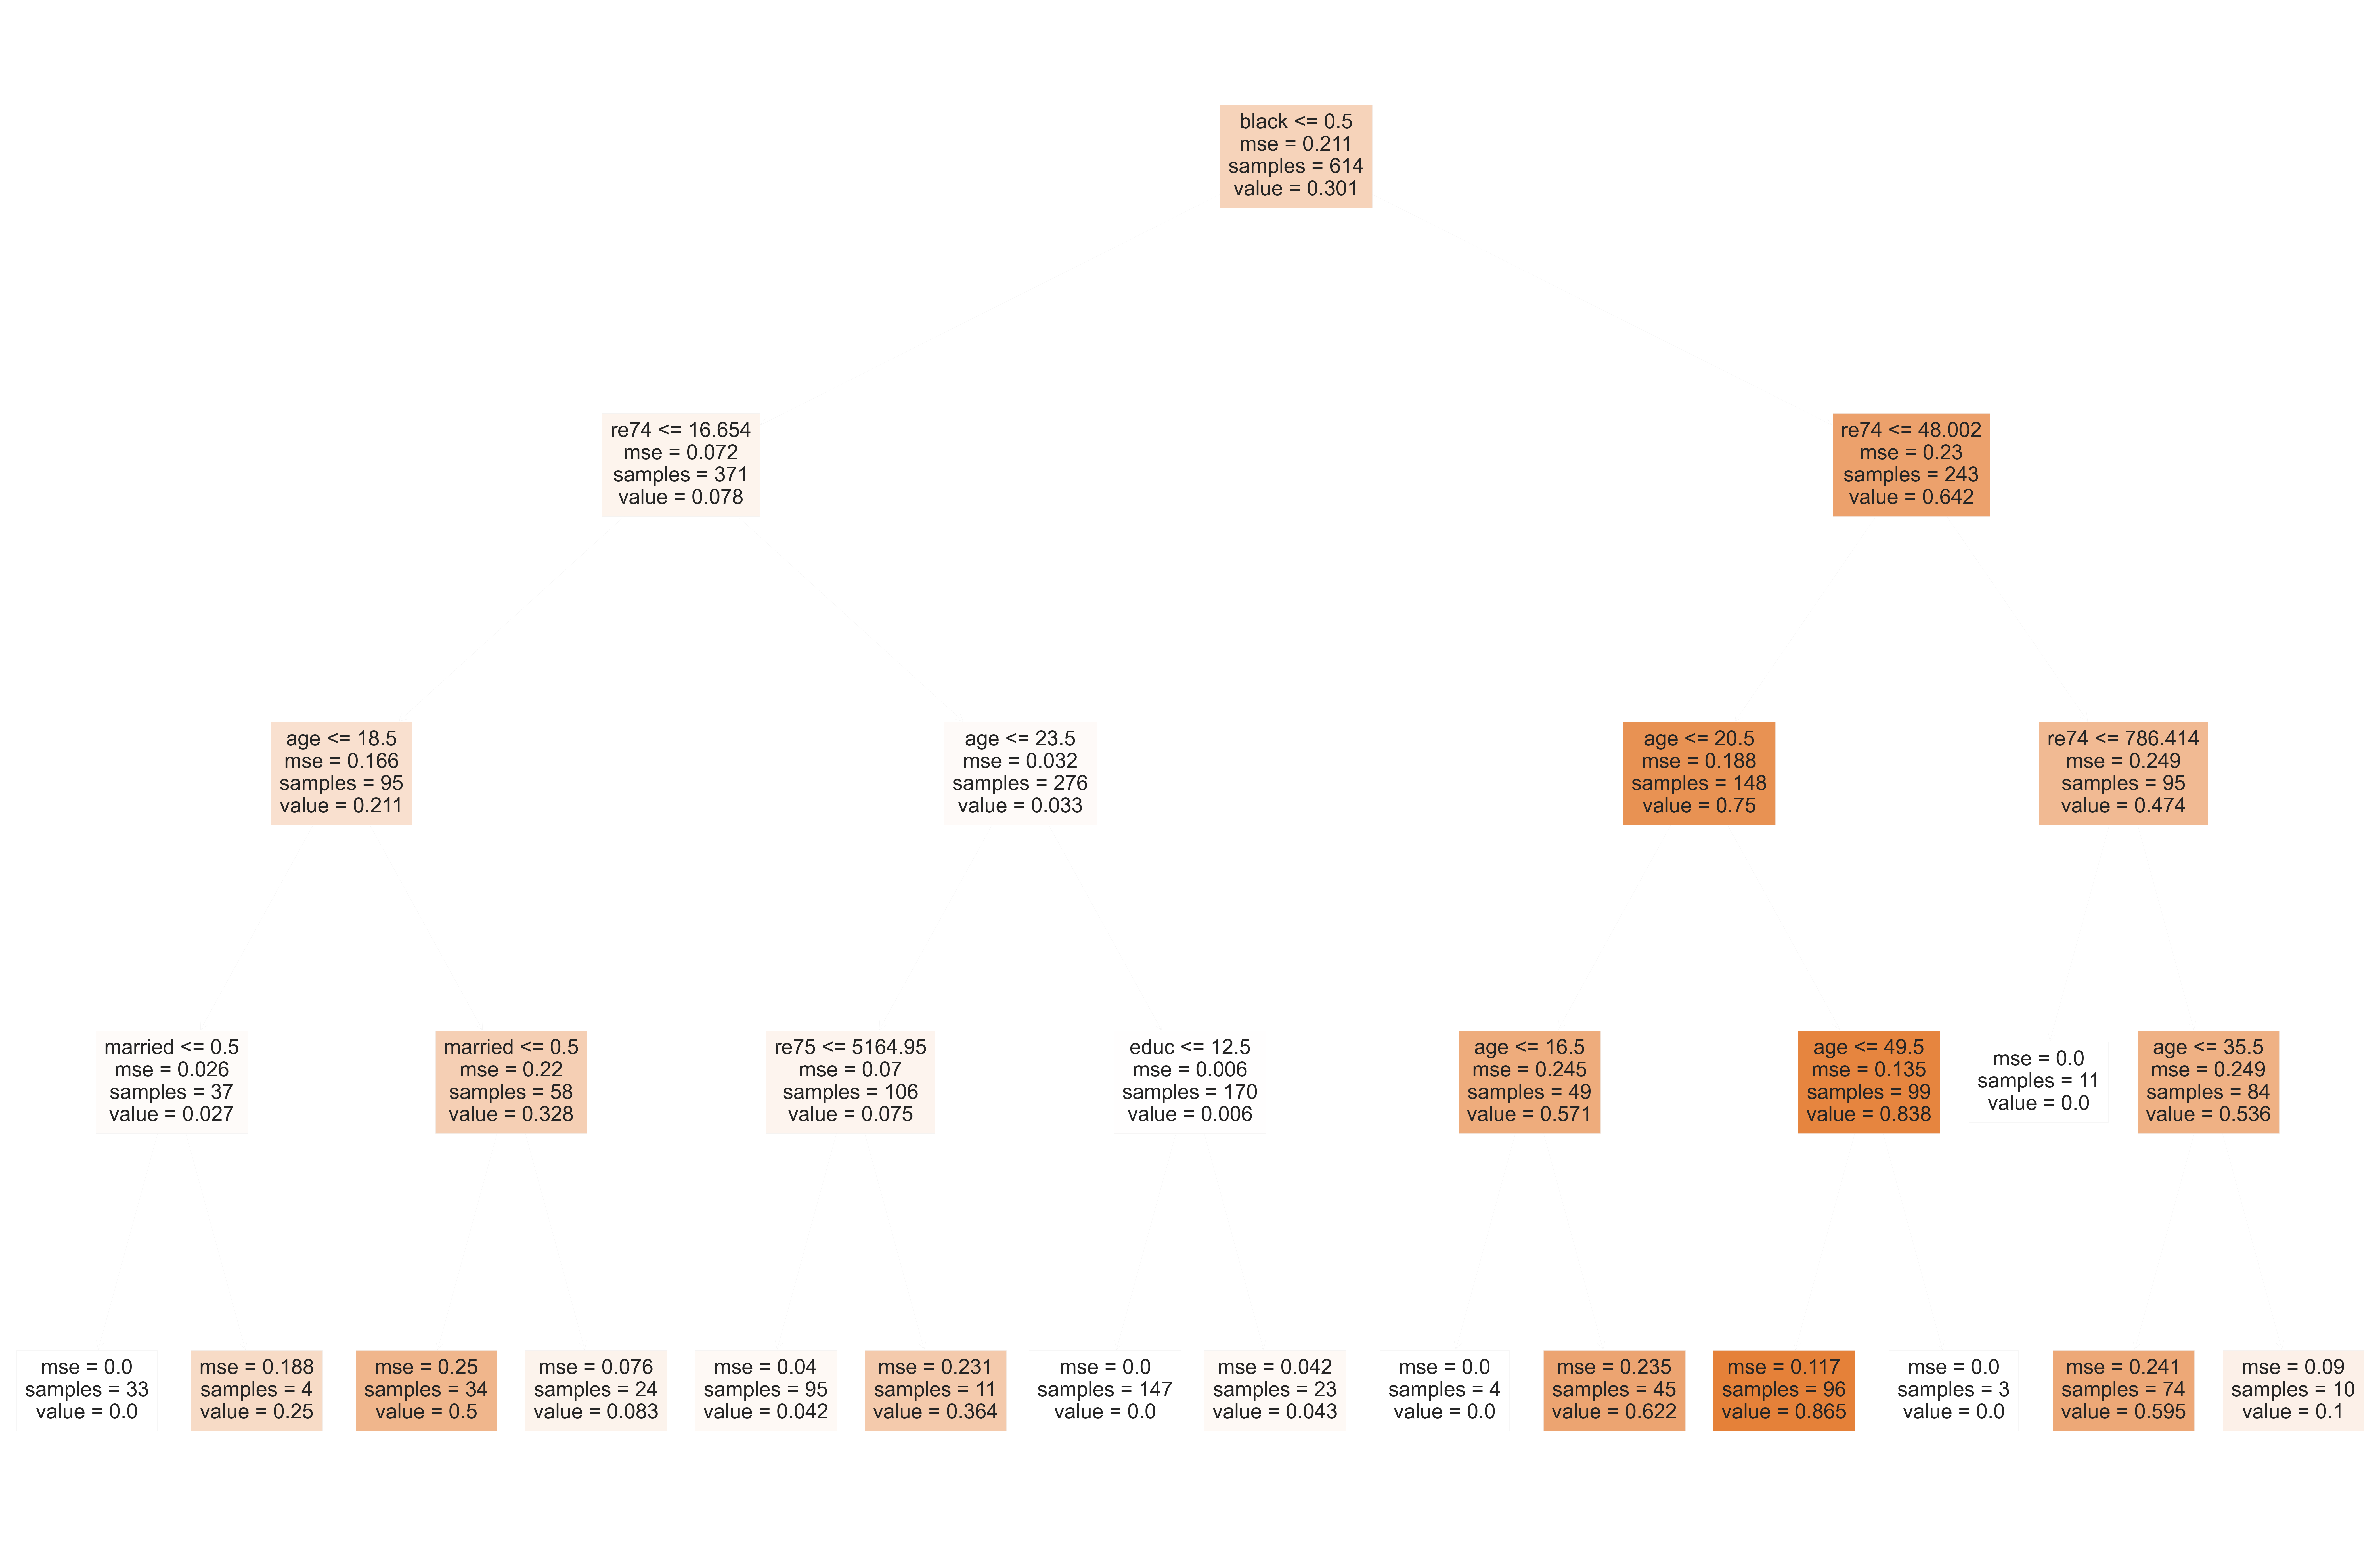

In [35]:
# Ploting the tree regressor
fig = plt.gcf()
fig.set_size_inches(150, 100)

tree.plot_tree(regressor,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree_plot.png')

-------

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.**

In [36]:
# Instantiate model
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4,random_state=42)

# Train model
rf.fit(cleaned_df, treatment)

# Predict
pscore_forest=rf.predict_proba(cleaned_df)[::,1]


-------

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.**

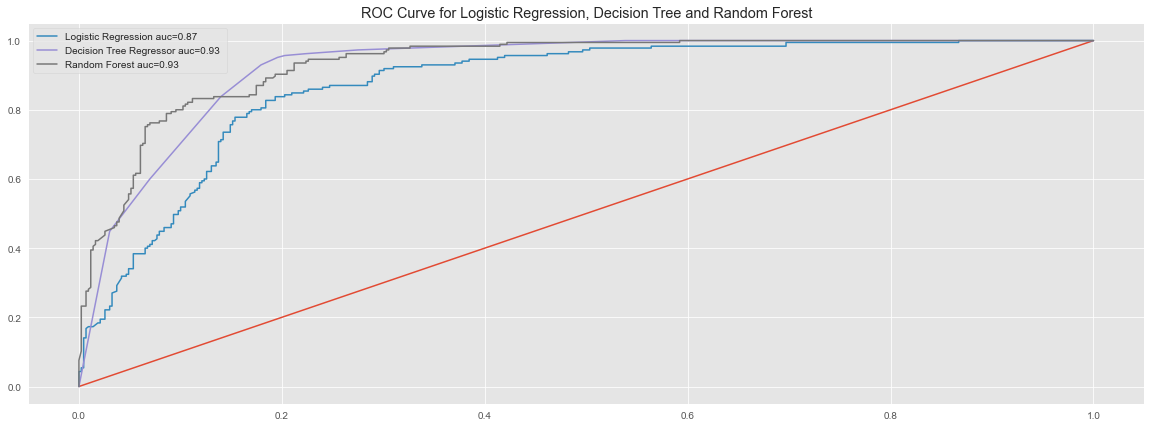

In [37]:
models_ec6 ={'Logistic Regression':pscore_logit,
             'Decision Tree Regressor':pscore_tree,
             'Random Forest':pscore_forest}

# Configuration 
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot([0, 1], [0, 1])

# Iteration by models
for model in models_ec6:
    fpr, tpr, _ = metrics.roc_curve(treatment, models_ec6[model])
    roc_auc     =metrics.auc(fpr, tpr)
    
    ax.plot(fpr,tpr,label=model+" auc=%s " % str(round(roc_auc,2)))
    plt.legend(loc=2)
    plt.title("ROC Curve for Logistic Regression, Decision Tree and Random Forest")

plt.show()

The random forest seems to perform better than the other models according to the indicator and the ROC curve graph.

-------

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

-------

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.**

-------

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.**

-------